In [3]:
# ---------------------------------------------------------
# Cholesterol Meal Plan Evaluation Notebook
# Author: Kshitiz Sikriwal
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True

# Dataset path
DATA_PATH = Path("/Users/kshitizsikriwal/Kshitiz/evaluation/GPT/meal_to_yoga_top1_contrastive_Cholesterol.xlsx")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ File not found: {DATA_PATH.resolve()}")

df = pd.read_excel(DATA_PATH, sheet_name=None)
sheet_name = list(df.keys())[0]
df = df[sheet_name]

print(f"✅ Loaded: {DATA_PATH.name} | Sheet: {sheet_name} | Shape: {df.shape}")
display(df.head(3))


✅ Loaded: meal_to_yoga_top1_contrastive_Cholesterol.xlsx | Sheet: Sheet1 | Shape: (42, 29)


,meal_index,meal_plan,meal_day,meal_time,meal_name,meal_description,Calories (kcal),Zinc (mg),Copper (mg),Iron (mg),...,Selenium (µg),Magnesium (mg),yoga_index,yoga_plan,yoga_day,yoga_time,yoga_detailed,yoga_exercise,yoga_precautions,similarity
0,0,Plan A,Monday,Morning,Spinach-mushroom omelette,Egg omelette with spinach and mushrooms.,664,2.54,0.36,5.08,...,19.78,126.71,42,Plan A,Monday,Morning,Practice Trikonasana and Tadasana for 10 minut...,Perform 35 minutes of continuous cycling or sw...,Avoid heavy or fatty meals prior to the sessio...,0.14
1,1,Plan A,Monday,Afternoon,Tofu stir-fry with brown rice,"Tofu and veggies stir-fried, served with brown...",784,3.00,0.43,5.65,...,23.13,150.93,55,Plan A,Friday,Afternoon,Practice Trikonasana and Tadasana for 10 minut...,Perform 35 minutes of continuous cycling or sw...,Avoid heavy or fatty meals prior to the sessio...,0.19
2,2,Plan A,Monday,Evening,Baked cod with sautéed spinach,Baked cod with garlic sautéed spinach.,660,2.52,0.36,4.76,...,19.78,121.75,50,Plan A,Wednesday,Evening,Practice Trikonasana and Tadasana for 10 minut...,Perform 35 minutes of continuous cycling or sw...,Avoid heavy or fatty meals prior to the sessio...,0.20


In [4]:
# ---------------------------------------------------------
# Normalize column names & detect plan/day columns
# ---------------------------------------------------------
def canon(txt):
    if pd.isna(txt): return txt
    return "_".join(str(txt).strip().lower().split())

df.columns = [canon(c) for c in df.columns]

plan_col = next((c for c in df.columns if "plan" in c), None)
day_col  = next((c for c in df.columns if "day" in c), None)
if not plan_col or not day_col:
    raise ValueError(f"❌ Could not auto-detect plan/day columns. Columns found: {df.columns.tolist()}")

df[plan_col] = df[plan_col].astype(str).apply(canon)
df[day_col]  = df[day_col].astype(str).apply(canon)

print(f"🧩 Plan column: {plan_col} | Day column: {day_col}")
print("Detected plans:", df[plan_col].unique())
print("Detected days:", df[day_col].unique())


🧩 Plan column: meal_plan | Day column: meal_day
Detected plans: ['plan_a' 'plan_b']
Detected days: ['monday' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']


In [3]:
# ---------------------------------------------------------
# Robust nutrient mapping (15 nutrients)
# ---------------------------------------------------------
nutrient_patterns = {
    "Calories (kcal)"        : ["calorie","energy","kcal"],
    "Zinc (mg)"              : ["zinc"],
    "Copper (mg)"            : ["copper"],
    "Iron (mg)"              : ["iron"],
    "Chromium (µg)"          : ["chromium"],
    "Potassium (mg)"         : ["potassium","k"],
    "Phosphorus (mg)"        : ["phosphorus","phosphate"],
    "Vitamin B1 (Thiamin) (mg)" : ["thiamin","vitamin_b1","b1"],
    "Vitamin B2 (Riboflavin) (mg)" : ["riboflavin","vitamin_b2","b2"],
    "Vitamin B3 (Niacin) (mg)"    : ["niacin","vitamin_b3","b3"],
    "Vitamin B6 (mg)"         : ["vitamin_b6","b6"],
    "Vitamin B9 (Folate) (µg)" : ["folate","folic","vitamin_b9","b9"],
    "Vitamin B12 (µg)"        : ["vitamin_b12","b12"],
    "Selenium (µg)"           : ["selenium","se"],
    "Magnesium (mg)"          : ["magnesium","mg"]
}

matched = {}
for friendly, pats in nutrient_patterns.items():
    for p in pats:
        hit = next((col for col in df.columns if p in col), None)
        if hit:
            matched[friendly] = hit
            break

print("🧮 Nutrient Mapping:")
for k,v in matched.items():
    print(f"  {k:30s} → {v}")

found_cols = list(matched.values())
if not found_cols:
    raise ValueError("❌ No nutrient columns found!")

for c in found_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


🧮 Nutrient Mapping:
  Calories (kcal)                → calories_(kcal)
  Zinc (mg)                      → zinc_(mg)
  Copper (mg)                    → copper_(mg)
  Iron (mg)                      → iron_(mg)
  Chromium (µg)                  → chromium_(µg)
  Potassium (mg)                 → potassium_(mg)
  Phosphorus (mg)                → phosphorus_(mg)
  Vitamin B1 (Thiamin) (mg)      → vitamin_b1_(thiamin,_mg)
  Vitamin B2 (Riboflavin) (mg)   → vitamin_b2_(riboflavin,_mg)
  Vitamin B3 (Niacin) (mg)       → vitamin_b3_(niacin,_mg)
  Vitamin B6 (mg)                → vitamin_b6_(mg)
  Vitamin B9 (Folate) (µg)       → vitamin_b9_(folate,_µg)
  Vitamin B12 (µg)               → vitamin_b12_(µg)
  Selenium (µg)                  → selenium_(µg)
  Magnesium (mg)                 → magnesium_(mg)


In [4]:
# ---------------------------------------------------------
# Aggregate daily totals → compute weekly averages
# ---------------------------------------------------------
daily_totals = (
    df.groupby([plan_col, day_col], as_index=False)[found_cols]
      .sum().sort_values([plan_col, day_col])
)
weekly_avg = daily_totals.groupby(plan_col)[found_cols].mean()

dataset_to_friendly = {v:k for k,v in matched.items()}

def make_series(plan_name):
    if plan_name not in weekly_avg.index:
        return pd.Series(dtype=float)
    return weekly_avg.loc[plan_name].rename(index=dataset_to_friendly)

weekly_avg_main = make_series("plan_a")
weekly_avg_alt  = make_series("plan_b")

print("✅ Weekly Averages Computed")
display(weekly_avg_main.round(2))
display(weekly_avg_alt.round(2))


✅ Weekly Averages Computed


Calories (kcal)                2064.29
Zinc (mg)                         9.40
Copper (mg)                       1.14
Iron (mg)                        12.67
Chromium (µg)                    30.67
Potassium (mg)                 4016.77
Phosphorus (mg)                 935.03
Vitamin B1 (Thiamin) (mg)         1.16
Vitamin B2 (Riboflavin) (mg)      1.17
Vitamin B3 (Niacin) (mg)         22.51
Vitamin B6 (mg)                   1.74
Vitamin B9 (Folate) (µg)        361.88
Vitamin B12 (µg)                  2.93
Selenium (µg)                    59.94
Magnesium (mg)                  365.60
Name: plan_a, dtype: float64

Calories (kcal)                1985.29
Zinc (mg)                         9.90
Copper (mg)                       1.09
Iron (mg)                        14.32
Chromium (µg)                    29.60
Potassium (mg)                 4225.70
Phosphorus (mg)                1040.87
Vitamin B1 (Thiamin) (mg)         1.15
Vitamin B2 (Riboflavin) (mg)      1.23
Vitamin B3 (Niacin) (mg)         24.64
Vitamin B6 (mg)                   1.70
Vitamin B9 (Folate) (µg)        353.12
Vitamin B12 (µg)                  3.25
Selenium (µg)                    62.73
Magnesium (mg)                  371.40
Name: plan_b, dtype: float64

In [5]:
# ---------------------------------------------------------
# Real-world nutritional midpoints for cholesterol management
# ---------------------------------------------------------
guideline_mid = pd.Series({
    "Calories (kcal)"         : (1800 + 2200) / 2,   # 2000
    "Zinc (mg)"               : (8 + 11) / 2,        # 9.5
    "Copper (mg)"             : (0.9 + 1.3) / 2,     # 1.1
    "Iron (mg)"               : (8 + 18) / 2,        # 13
    "Chromium (µg)"           : (25 + 35) / 2,       # 30
    "Potassium (mg)"          : (3400 + 4700) / 2,   # 4050
    "Phosphorus (mg)"         : (700 + 1250) / 2,    # 975
    "Vitamin B1 (Thiamin) (mg)" : (1.1 + 1.2) / 2,   # 1.15
    "Vitamin B2 (Riboflavin) (mg)" : (1.1 + 1.3) / 2,# 1.2
    "Vitamin B3 (Niacin) (mg)"    : (14 + 35) / 2,   # 24.5
    "Vitamin B6 (mg)"         : (1.3 + 2.0) / 2,     # 1.65
    "Vitamin B9 (Folate) (µg)" : (300 + 400) / 2,    # 350
    "Vitamin B12 (µg)"        : (2.4 + 4.0) / 2,     # 3.2
    "Selenium (µg)"           : (55 + 70) / 2,       # 62.5
    "Magnesium (mg)"          : (310 + 420) / 2      # 365
})

guideline_mid = guideline_mid.reindex(weekly_avg_main.index)
print("📘 Cholesterol Guideline Midpoints")
display(guideline_mid.round(2))


📘 Cholesterol Guideline Midpoints


Calories (kcal)                2000.00
Zinc (mg)                         9.50
Copper (mg)                       1.10
Iron (mg)                        13.00
Chromium (µg)                    30.00
Potassium (mg)                 4050.00
Phosphorus (mg)                 975.00
Vitamin B1 (Thiamin) (mg)         1.15
Vitamin B2 (Riboflavin) (mg)      1.20
Vitamin B3 (Niacin) (mg)         24.50
Vitamin B6 (mg)                   1.65
Vitamin B9 (Folate) (µg)        350.00
Vitamin B12 (µg)                  3.20
Selenium (µg)                    62.50
Magnesium (mg)                  365.00
dtype: float64

In [6]:
# ---------------------------------------------------------
# Compute MAE, MSE, RMSE per plan
# ---------------------------------------------------------
def compute_errors(pred, real):
    df_err = pd.DataFrame({"Predicted": pred, "Guideline": real})
    df_err["Absolute Error"] = (df_err["Predicted"] - df_err["Guideline"]).abs()
    df_err["Percentage Error (%)"] = (df_err["Absolute Error"] / df_err["Guideline"]) * 100
    mae = df_err["Absolute Error"].mean()
    mse = (df_err["Absolute Error"] ** 2).mean()
    rmse = np.sqrt(mse)
    metrics = pd.Series({"MAE": mae, "MSE": mse, "RMSE": rmse}).round(3)
    return df_err.round(2), metrics

main_errors, main_metrics = compute_errors(weekly_avg_main, guideline_mid)
alt_errors,  alt_metrics  = compute_errors(weekly_avg_alt,  guideline_mid)

print("📈 Cholesterol — Plan A (Main) Errors")
display(main_errors)
display(main_metrics)

print("\n📈 Cholesterol — Plan B (Alternate) Errors")
display(alt_errors)
display(alt_metrics)


📈 Cholesterol — Plan A (Main) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),2064.29,2000.00,64.29,3.21
Zinc (mg),9.40,9.50,0.10,1.07
Copper (mg),1.14,1.10,0.04,4.01
Iron (mg),12.67,13.00,0.33,2.52
Chromium (µg),30.67,30.00,0.67,2.23
Potassium (mg),4016.77,4050.00,33.23,0.82
Phosphorus (mg),935.03,975.00,39.97,4.10
Vitamin B1 (Thiamin) (mg),1.16,1.15,0.01,1.04
Vitamin B2 (Riboflavin) (mg),1.17,1.20,0.03,2.20
Vitamin B3 (Niacin) (mg),22.51,24.50,1.99,8.13


MAE     10.40
MSE    465.81
RMSE    21.58
dtype: float64


📈 Cholesterol — Plan B (Alternate) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1985.29,2000.00,14.71,0.74
Zinc (mg),9.90,9.50,0.40,4.25
Copper (mg),1.09,1.10,0.01,0.64
Iron (mg),14.32,13.00,1.32,10.14
Chromium (µg),29.60,30.00,0.40,1.35
Potassium (mg),4225.70,4050.00,175.70,4.34
Phosphorus (mg),1040.87,975.00,65.87,6.76
Vitamin B1 (Thiamin) (mg),1.15,1.15,0.00,0.22
Vitamin B2 (Riboflavin) (mg),1.23,1.20,0.03,2.87
Vitamin B3 (Niacin) (mg),24.64,24.50,0.14,0.55


MAE      17.90
MSE    2365.25
RMSE     48.63
dtype: float64

,Guideline (Midpoint),Predicted (Plan A),Predicted (Plan B),Z-Score (Plan A),Z-Score (Plan B)
Calories (kcal),2000.00,2064.29,1985.29,0.06,-0.01
Zinc (mg),9.50,9.40,9.90,-0.00,0.00
Copper (mg),1.10,1.14,1.09,0.00,-0.00
Iron (mg),13.00,12.67,14.32,-0.00,0.00
Chromium (µg),30.00,30.67,29.59,0.00,-0.00
Potassium (mg),4050.00,4016.77,4225.70,-0.03,0.16
Phosphorus (mg),975.00,935.03,1040.87,-0.04,0.06
Vitamin B1 (Thiamin) (mg),1.15,1.16,1.15,0.00,0.00
Vitamin B2 (Riboflavin) (mg),1.20,1.17,1.23,-0.00,0.00
Vitamin B3 (Niacin) (mg),24.50,22.51,24.64,-0.00,0.00


🔹 Avg |Z| (Plan A) = 0.010
🔹 Avg |Z| (Plan B) = 0.017


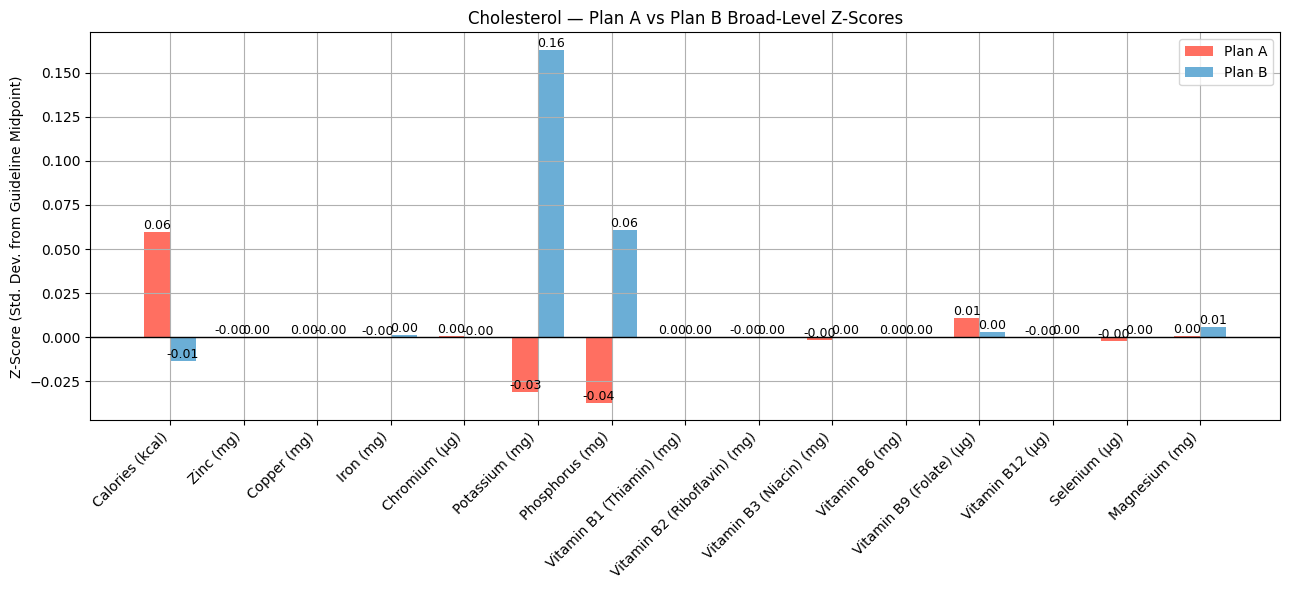

In [7]:
# ---------------------------------------------------------
# Broad-level Z-Score calculation (Plan A & Plan B)
# ---------------------------------------------------------
guideline_std = np.std(guideline_mid.values, ddof=0)

z_main = (weekly_avg_main.values - guideline_mid.values) / guideline_std
z_alt  = (weekly_avg_alt.values  - guideline_mid.values) / guideline_std

z_main_series = pd.Series(z_main, index=guideline_mid.index, name="Z-Score (Plan A)")
z_alt_series  = pd.Series(z_alt,  index=guideline_mid.index, name="Z-Score (Plan B)")

z_df = pd.DataFrame({
    "Guideline (Midpoint)": guideline_mid,
    "Predicted (Plan A)": weekly_avg_main,
    "Predicted (Plan B)": weekly_avg_alt,
    "Z-Score (Plan A)": z_main_series,
    "Z-Score (Plan B)": z_alt_series
}).round(3)

display(z_df)

avg_abs_z_main = np.abs(z_main_series).mean()
avg_abs_z_alt  = np.abs(z_alt_series).mean()
print(f"🔹 Avg |Z| (Plan A) = {avg_abs_z_main:.3f}")
print(f"🔹 Avg |Z| (Plan B) = {avg_abs_z_alt:.3f}")

# Plot Z-scores
x = np.arange(len(z_df.index))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(13,6))
bars1 = ax.bar(x - bar_width/2, z_main_series, width=bar_width, label="Plan A", color="#FF6F61")
bars2 = ax.bar(x + bar_width/2, z_alt_series,  width=bar_width, label="Plan B", color="#6BAED6")

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(z_df.index, rotation=45, ha='right')
ax.set_ylabel("Z-Score (Std. Dev. from Guideline Midpoint)")
ax.set_title("Cholesterol — Plan A vs Plan B Broad-Level Z-Scores")
ax.legend()
plt.tight_layout()
plt.show()
